# Introduction

This tutorial will focus on the Kmeans clustering algorithm. The goal of this algorithm is to separate the data points in a data set into k clusters. Kmeans is often used in data mining to find patterns in large data sets and gain some intuition about the data set using those patterns. Kmeans is also often used to preprocess datasets and generate starting configurations for other algorithms.

An example of applying Kmeans on a set of 2-d points, with k = 3, is shown below:
<img src="http://sherrytowers.com/wp-content/uploads/2013/10/kmeans_1.jpg" width="400" height="400" />

### Tutorial content

This tutorial will describe what the Kmeans clustering algorithm is, show how to implement it, and use a few examples to illustrate it in action. Kmeans is classified as unsupervised learning, so this tutorial will explain what that means, touching upon classification vs. clustering.

Sections:
1. Unsupervised learning and classification vs. clustering
2. Libraries needed
3. Loading data
4. Implementing Kmeans
5. Pros and cons of Kmeans
6. Example: Image compression with Kmeans
7. Related topics

# 1. Unsupervised learning and classification vs. clustering

So far,  we have seen many examples of supervised learning. One of these is linear regression. Supervised learning is where you are given data with labels, and must train a model based on this data to fit these labels. Given unknown data without labels, the model is used to predict the correct labels for the unknown data.

Unsupervised learning is the counterpart to this. In unsupervised learning, the data does not have any labels, and the goal is to try to gain some intuition about similarities within the data.

### Classification vs. Clustering

In classification, we are provided with data for which we know what groups they belong to. This comes from their labels. The goal is to learn how to predict these groups and classify data given to us in the future.

In clustering, we are provided with data for which we don't know the groups they belong to. In addition to this, the groups that are possible are not defined. The goal is to learn what groups exist and how to differentiate them from one another.

# 2. Libraries needed

We will need `pandas` to load our data, `numpy` to hold our data in arrays, and `matplotlib` to visualize the results of Kmeans. We will also need `Axes3D` to visualize three dimensional data. Finally, we need the `os` imports to read all the files in a directory.

In [1]:
from os import listdir
from os.path import join
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (30, 20)

from mpl_toolkits.mplot3d import Axes3D

# 3. Loading data

We first need data to run the algorithm on. We will be using a data set from the UCI Machine Learning Repository called the Dataset for ADL Recognition with Wrist-worn Accelerometer Data Set. This data set consists of tri-axial accelerometer data collected from individuals while they did activities of daily living (ADL). We will be using the data collected from three individuals brushing teeth. This contains roughly 5200 data points.

Download the `ADL_Dataset.zip` file from http://archive.ics.uci.edu/ml/machine-learning-databases/00283/. Then, unzip the folder into your working directory.

The code below loads the data. The `.txt` files in the `Brush_teeth` directory are space separated, so the delimiter is set to `' '`. Since collecting data from more than three individuals will make the graph of the data harder to understand, we only load from the first three `.txt` files.

In [2]:
brush_folder = "ADL_Dataset\HMP_Dataset\Brush_teeth"
brush_df = pd.DataFrame(columns=list("xyz"))
for brush_file in listdir(brush_folder)[:3]:
    next_df = pd.read_csv(join(brush_folder,brush_file), delimiter=' ', names=list("xyz"))
    brush_df = brush_df.append(next_df, ignore_index=True)
print(brush_df.shape)
brush_df.head()

(5239, 3)


,x,y,z
0,22,49,35
1,22,49,35
2,22,52,35
3,22,52,35
4,21,52,34


The code below shows how the data collected looks. The data is converted to a `np.ndarray` type, then we use an `Axes3D` object to plot it. The scatter plot is a little cluttered, but the many points in the center allow us to perceive the depth of the graph a little bit better, especially once the clusters are colored. Thus the decision to use three individuals' data, and not just one.

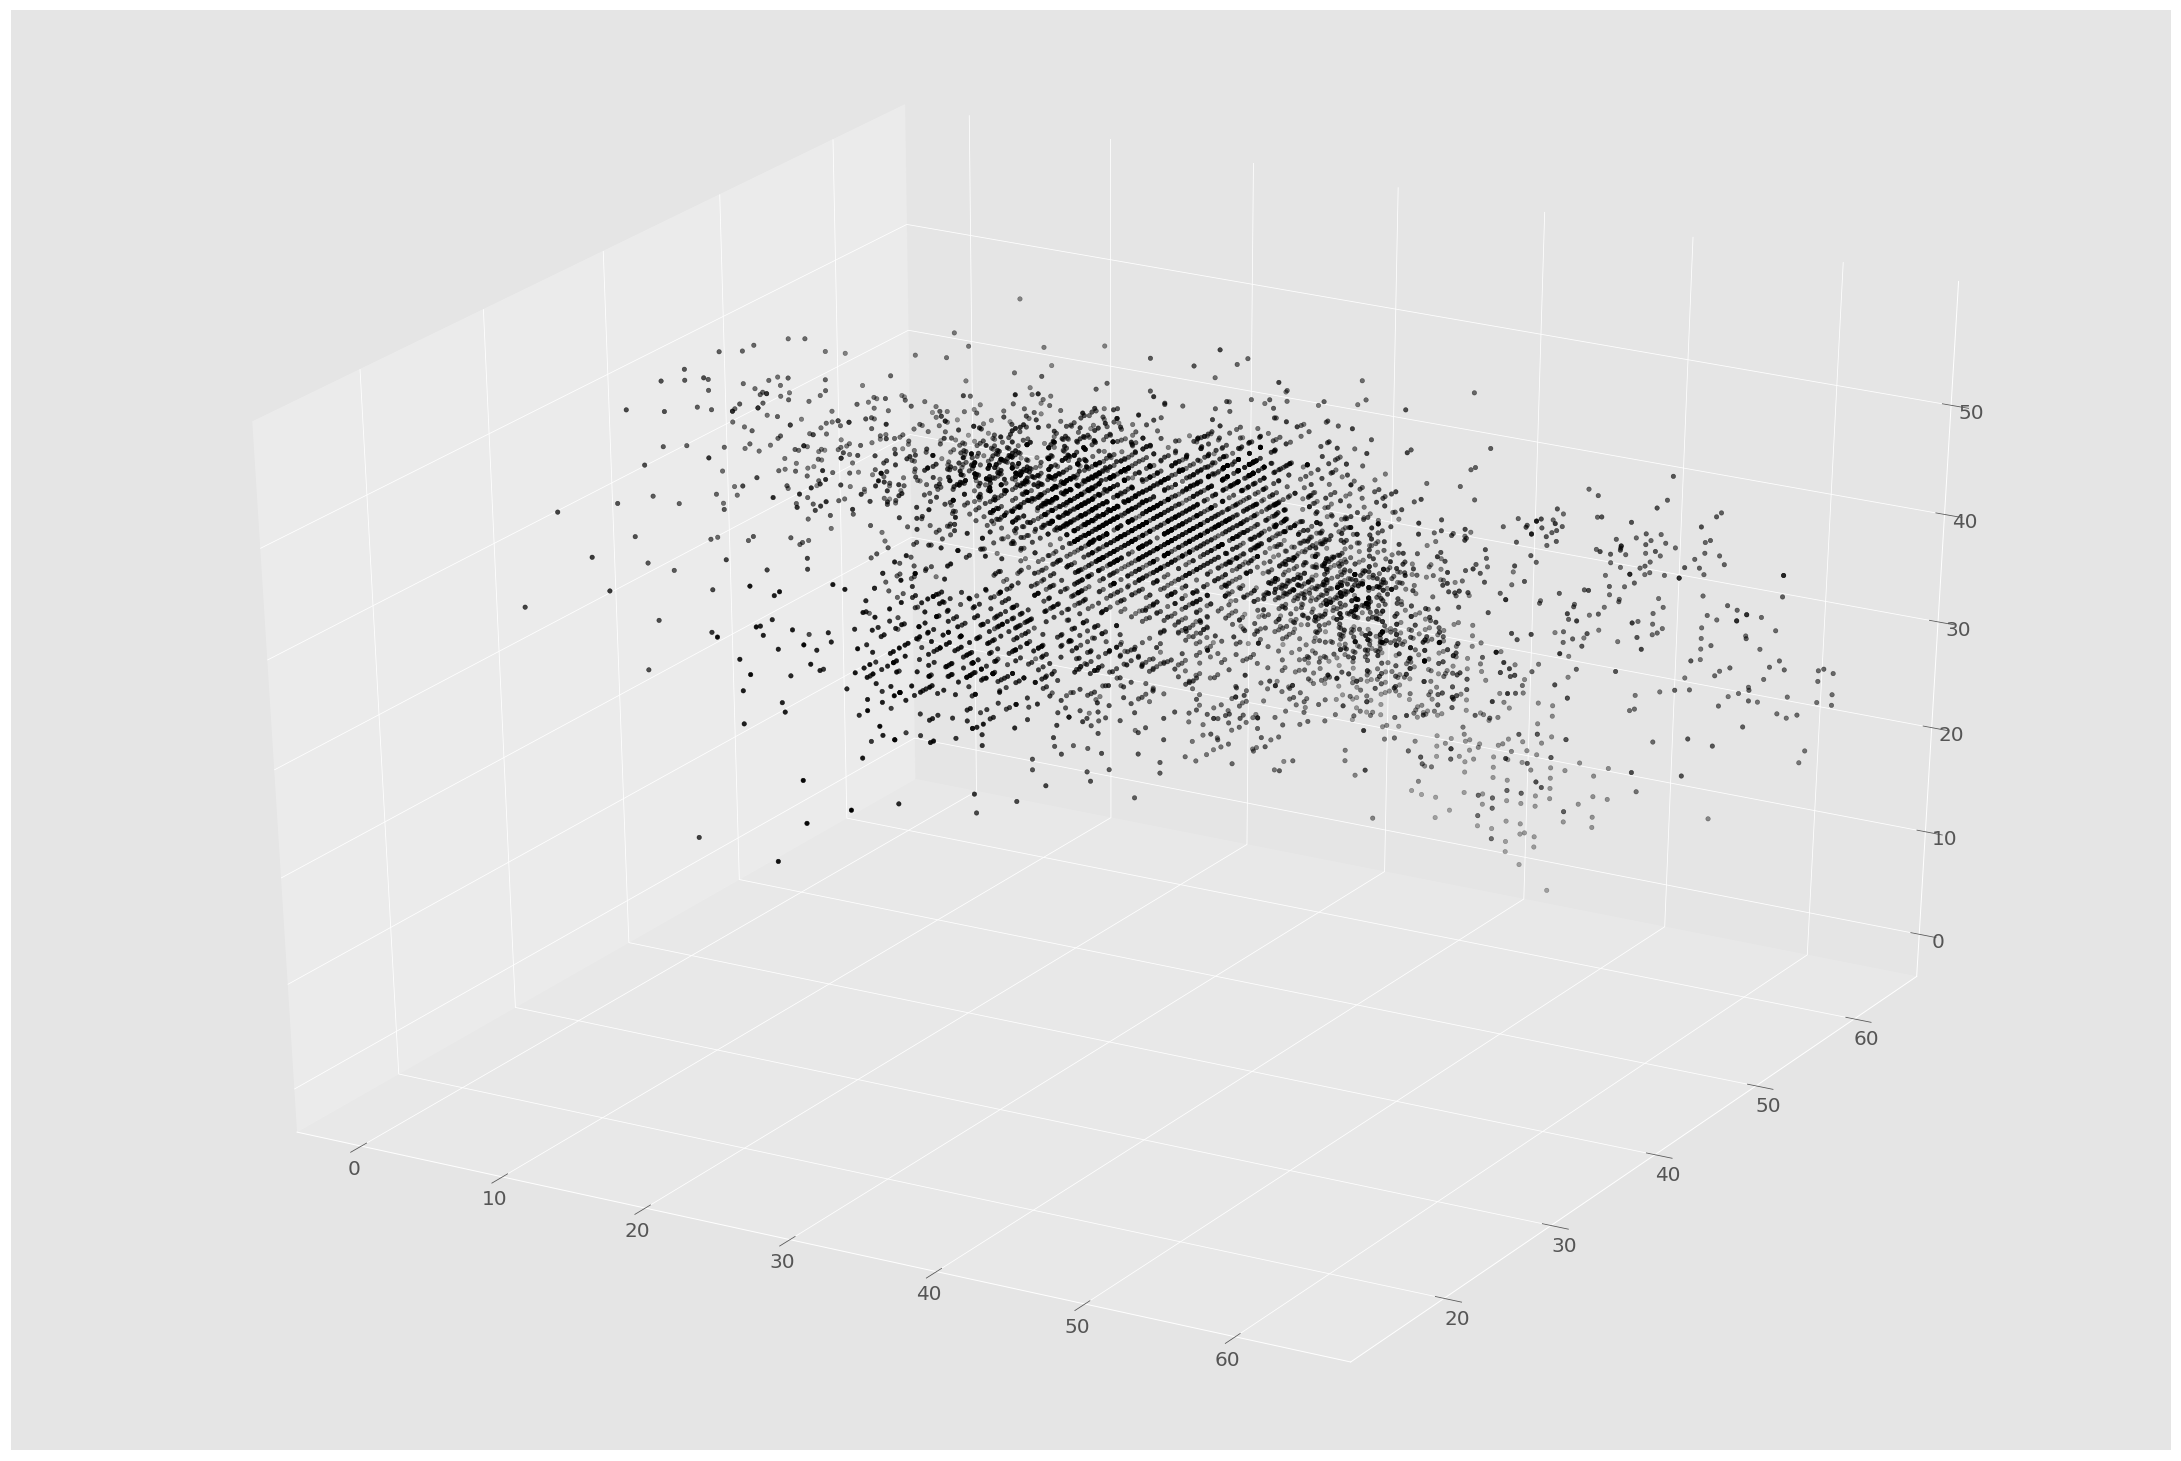

In [3]:
# get matrix representation of dataframe
brush_data = brush_df.as_matrix()

# plot data with black data points and large labels
figure = Axes3D(plt.figure())
figure.scatter(brush_data[:, 0], brush_data[:, 1], brush_data[:, 2], c='black')
figure.tick_params(axis='both', which='major', labelsize=20)

# 4. Implementing KMeans

Given $K$ and a data set $X$ = $X_{1}...X_{n}$ to classify, the Kmeans algorithm involves the following steps:
1. Pick $K$ random points from $X$ to act as your initial guesses for the cluster centers (centroids).
2. For each point $X_{i}$, find the closest centroid $c_{k}$ and label $X_{i}$ with $c(X_{i}) = c_{k}$. We will define closest as meaning the smallest euclidean distance.
3. For each centroid $c_{k}$, update $c_{k}$ as being the average of all the points within that cluster.
4. Repeat steps 2 and 3 until the clusters are constant.

The first step is to pick $K$ random points from the data to act as your initial guesses for the centroids, using `init_centroid_matrix`. It uses `np.random.choice` to choose random points, and we select set `replace` to `False` to avoid using the same centroid more than once. The centroids are stored in a `np.ndarray`, with each row being a centroid. We will use $K=7$.

In [4]:
def init_centroid_matrix(K, data_matrix):
    """
    Calculates K random points from the data to act as cluster center guesses
    
    Args:
        K (int): number of clusters
        data_matrix (np.ndarray): array of data, each row being a data point
    
    Returns:
        centroid_matrix (np.ndarray): array of centroid guesses, each row being a centroid
    """
        
    # kth list in centroids represents the kth centroid guess
    centroids = []
    
    # get coordinates for the centroid guesses
    for index in np.random.choice(data_matrix.shape[0], K, replace=False):
        row = data_matrix[index,:]
        centroids.append(row)

    # create matrix for centroid guesses, each row being a centroid
    centroid_matrix = np.vstack(tuple(centroids))
    
    return centroid_matrix

brush_centroids = init_centroid_matrix(7, brush_data)

brush_centroids

array([[32, 50, 43],
       [23, 49, 35],
       [26, 51, 37],
       [29, 43, 37],
       [26, 59, 31],
       [22, 51, 43],
       [20, 53, 44]], dtype=object)

The code below displays the cluster center guesses with red triangle markers, resized to be larger and opaque to see them better.

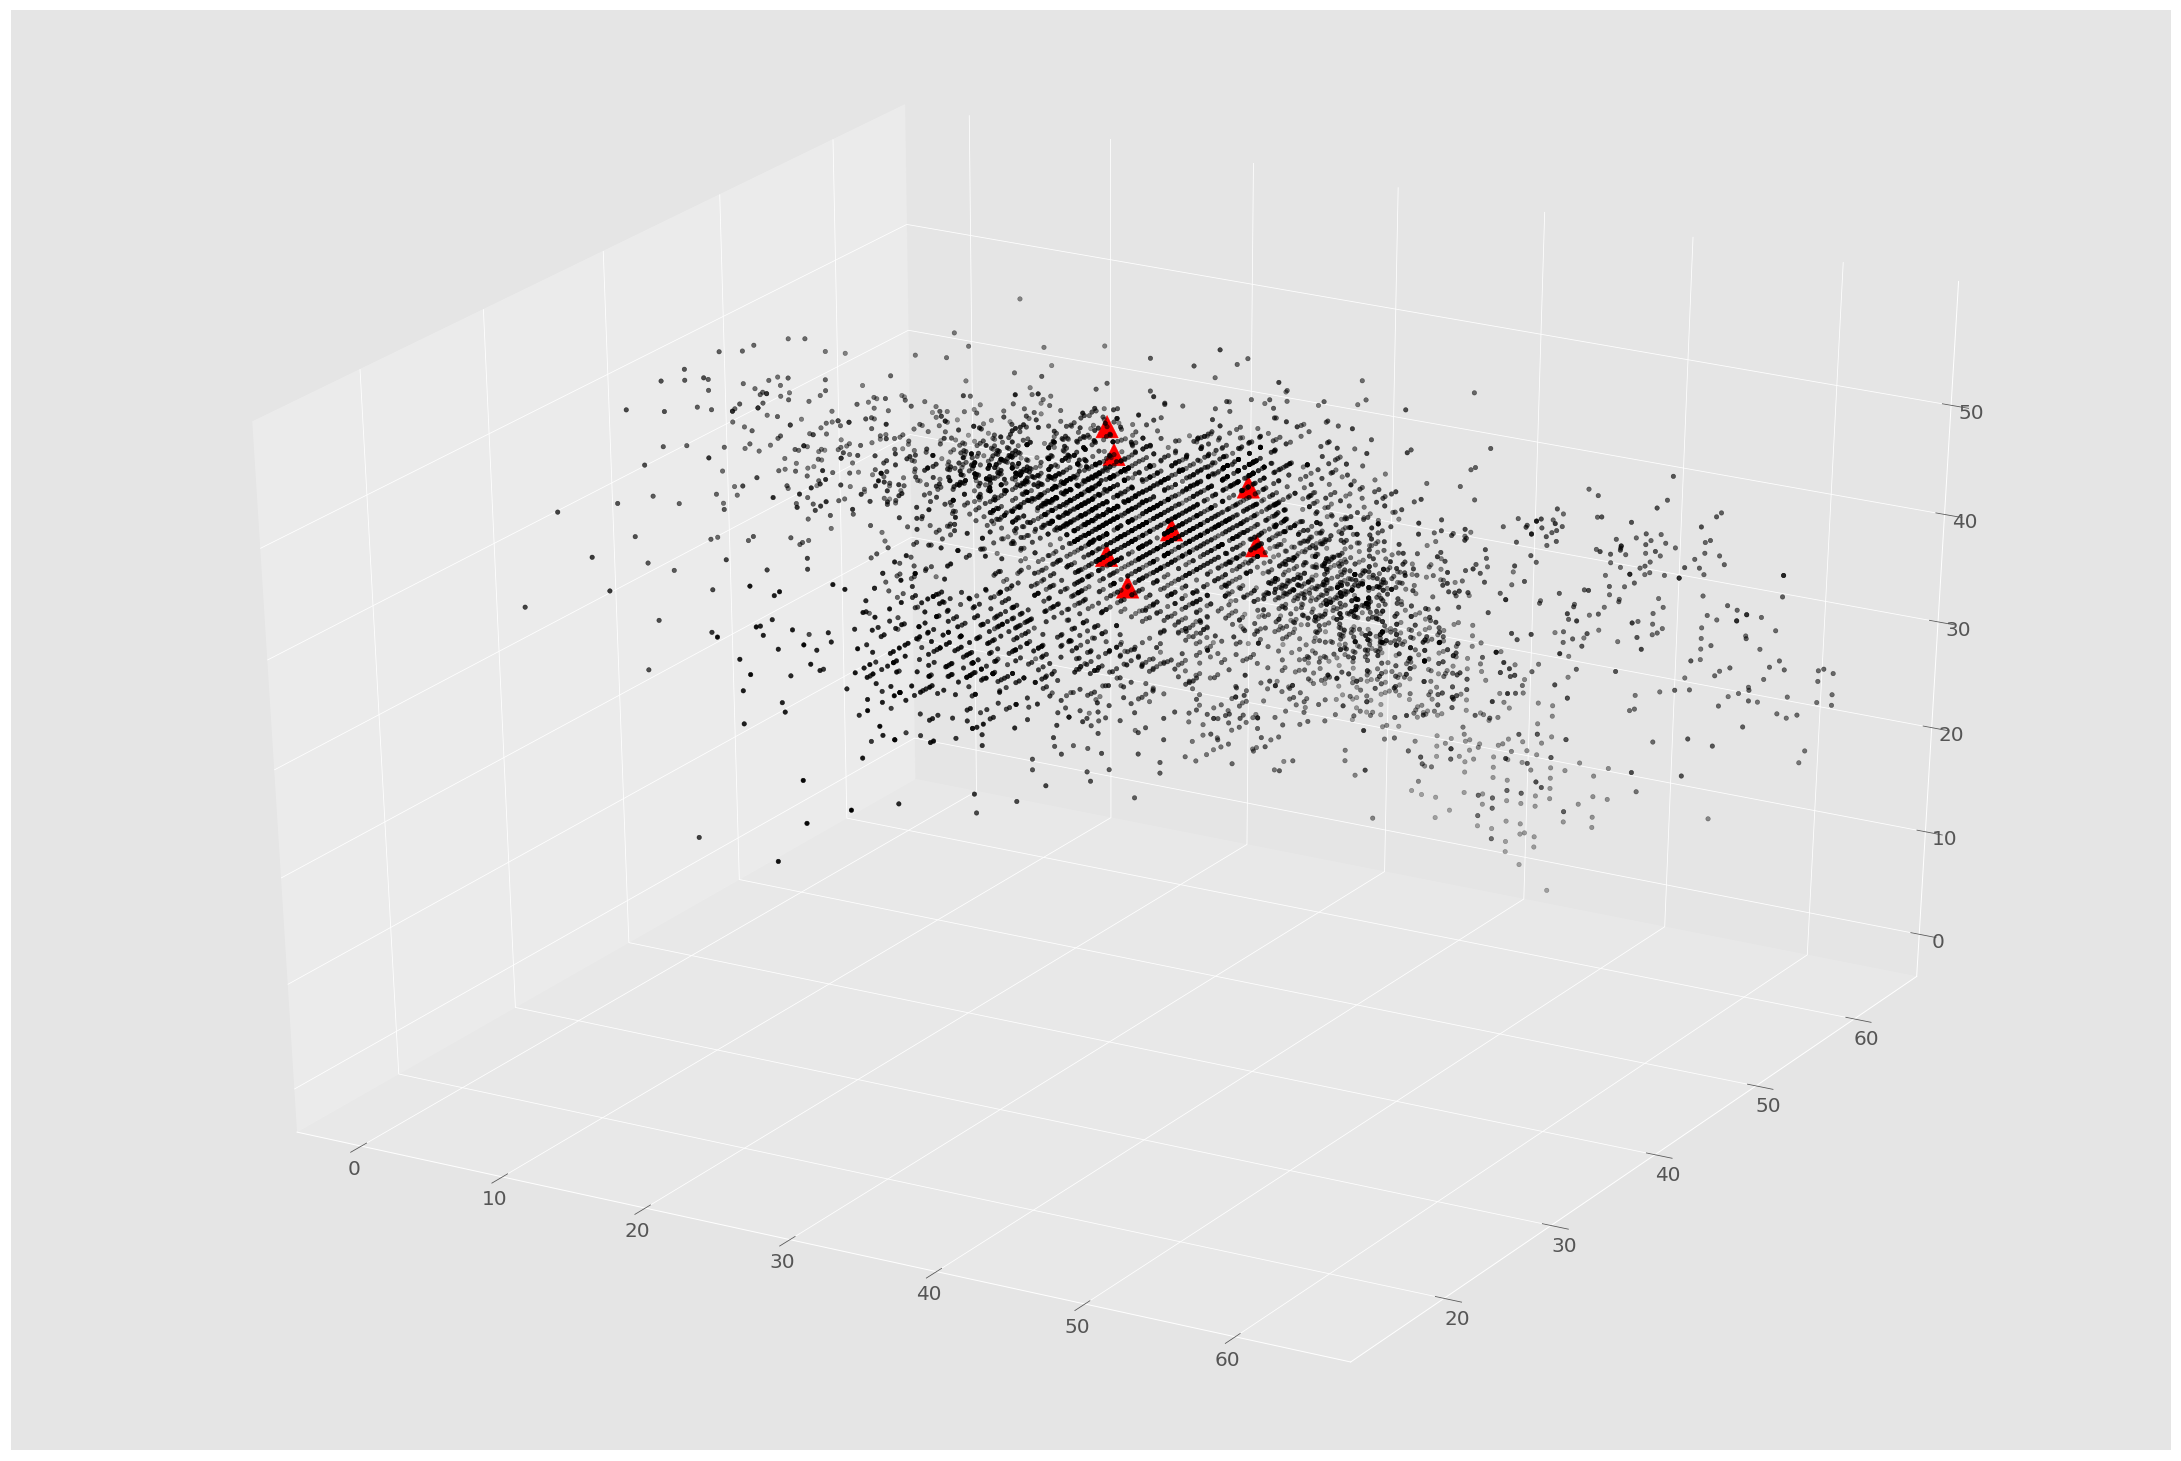

In [5]:
# replot data with center guesses marked
figure = Axes3D(plt.figure())
figure.scatter(brush_data[:, 0], brush_data[:, 1], brush_data[:, 2], c='black')
figure.scatter(brush_centroids[:, 0], brush_centroids[:, 1], brush_centroids[:, 2], c='red', s=500, marker='^', alpha=1)
figure.tick_params(axis='both', which='major', labelsize=20)

Steps two and three involve finding the closest cluster center for each point in the data set and updating each cluster center as being the avarage of all the points within that cluster. In step four, these two steps are repeated until the clusters converge. `converge_clusters` implements steps two through four. It uses `data_labels` to hold the values for $c(X_{i})$, iterating across all the $X_{i}$ and recalculating euclidean distance from each centroid to find the `new_data_label` for $X_{i}$. If the `new_data_label` doesn't match the old one from `data_labels[i]`, the algorithm has not converged yet. If at any point an empty cluster is encounter, a random point from the data is chosen as a centroid instead.

In [6]:
def converge_clusters(K, data_matrix, centroid_matrix):
    """
    Labels each point to a cluster and recalculates the centroids, repeating until convergence.
    
    Args:
        K (int): number of clusters
        data_matrix (np.ndarray): array of data
        centroid_matrix (np.ndarray): array of centroid guesses
    
    Returns:
        data_labels (list): list of cluster labels for each data point
        final_centroid_matrix (np.ndarray): array of final centroids
    """
    
    # get n and number of axes
    n,axes = data_matrix.shape
    
    # initialize data labels with bogus values
    data_labels = [K+1] * n
    
    # init converged to False
    converged = False

    while (not converged):
        
        # converged will remain True unless data_labels changes
        converged = True

        # iterate across all data points
        for point_num in range(n):
            point = data_matrix[point_num,:]
            smallest_dist = -1
            new_data_label = data_labels[point_num]

            # iterate across all centroids and find closest one
            for cluster_num in range(K):
                centroid = centroid_matrix[cluster_num,:]
                euc_dist = np.linalg.norm(point - centroid)
                if ((smallest_dist == -1) or (euc_dist < smallest_dist)):
                    smallest_dist = euc_dist
                    new_data_label = cluster_num

            # check if data label for point needs to be updated
            if (new_data_label != data_labels[point_num]):
                data_labels[point_num] = new_data_label
                converged = False

        # get new coordinates for all the centroids
        centroids = []
        
        sum_points = [0] * axes
        num_points = 0
        for cluster_num in range(K):
            # sum up all points in each cluster
            for point_num in range(n):
                if (data_labels[point_num] == cluster_num):
                    point = data_matrix[point_num]
                    for axis in range(axes):
                        sum_points[axis] += point[axis]
                    num_points += 1
            
            if (num_points > 0):
                # find average of each axis
                for axis in range(axes):
                    sum_points[axis] /= num_points

                # add new centroid
                centroids.append(sum_points)
            
            else:
                # add random point
                centroids.append(list(data_matrix[np.random.choice(data_matrix.shape[0]),:]))
                
            # reset sum_points and num_points
            sum_points = [0] * axes
            num_points = 0

        # calculate new cluster center matrix
        final_centroid_matrix = np.vstack(tuple(centroids))
    
    return data_labels, final_centroid_matrix

brush_labels, final_brush_centroids = converge_clusters(7, brush_data, brush_centroids)
final_brush_centroids

array([[ 38.0821382 ,  50.66101695,  40.81225554],
       [ 20.62586926,  48.85674548,  34.40611961],
       [ 27.79452055,  51.83105023,  36.11111111],
       [ 28.00837321,  36.56100478,  36.52751196],
       [ 33.58394758,  59.26945127,  24.54135954],
       [ 21.2276176 ,  46.58270106,  43.33080425],
       [  9.83157895,  50.78684211,  41.91578947]])

`plot_results` plots the results of performing Kmeans on the dataset.

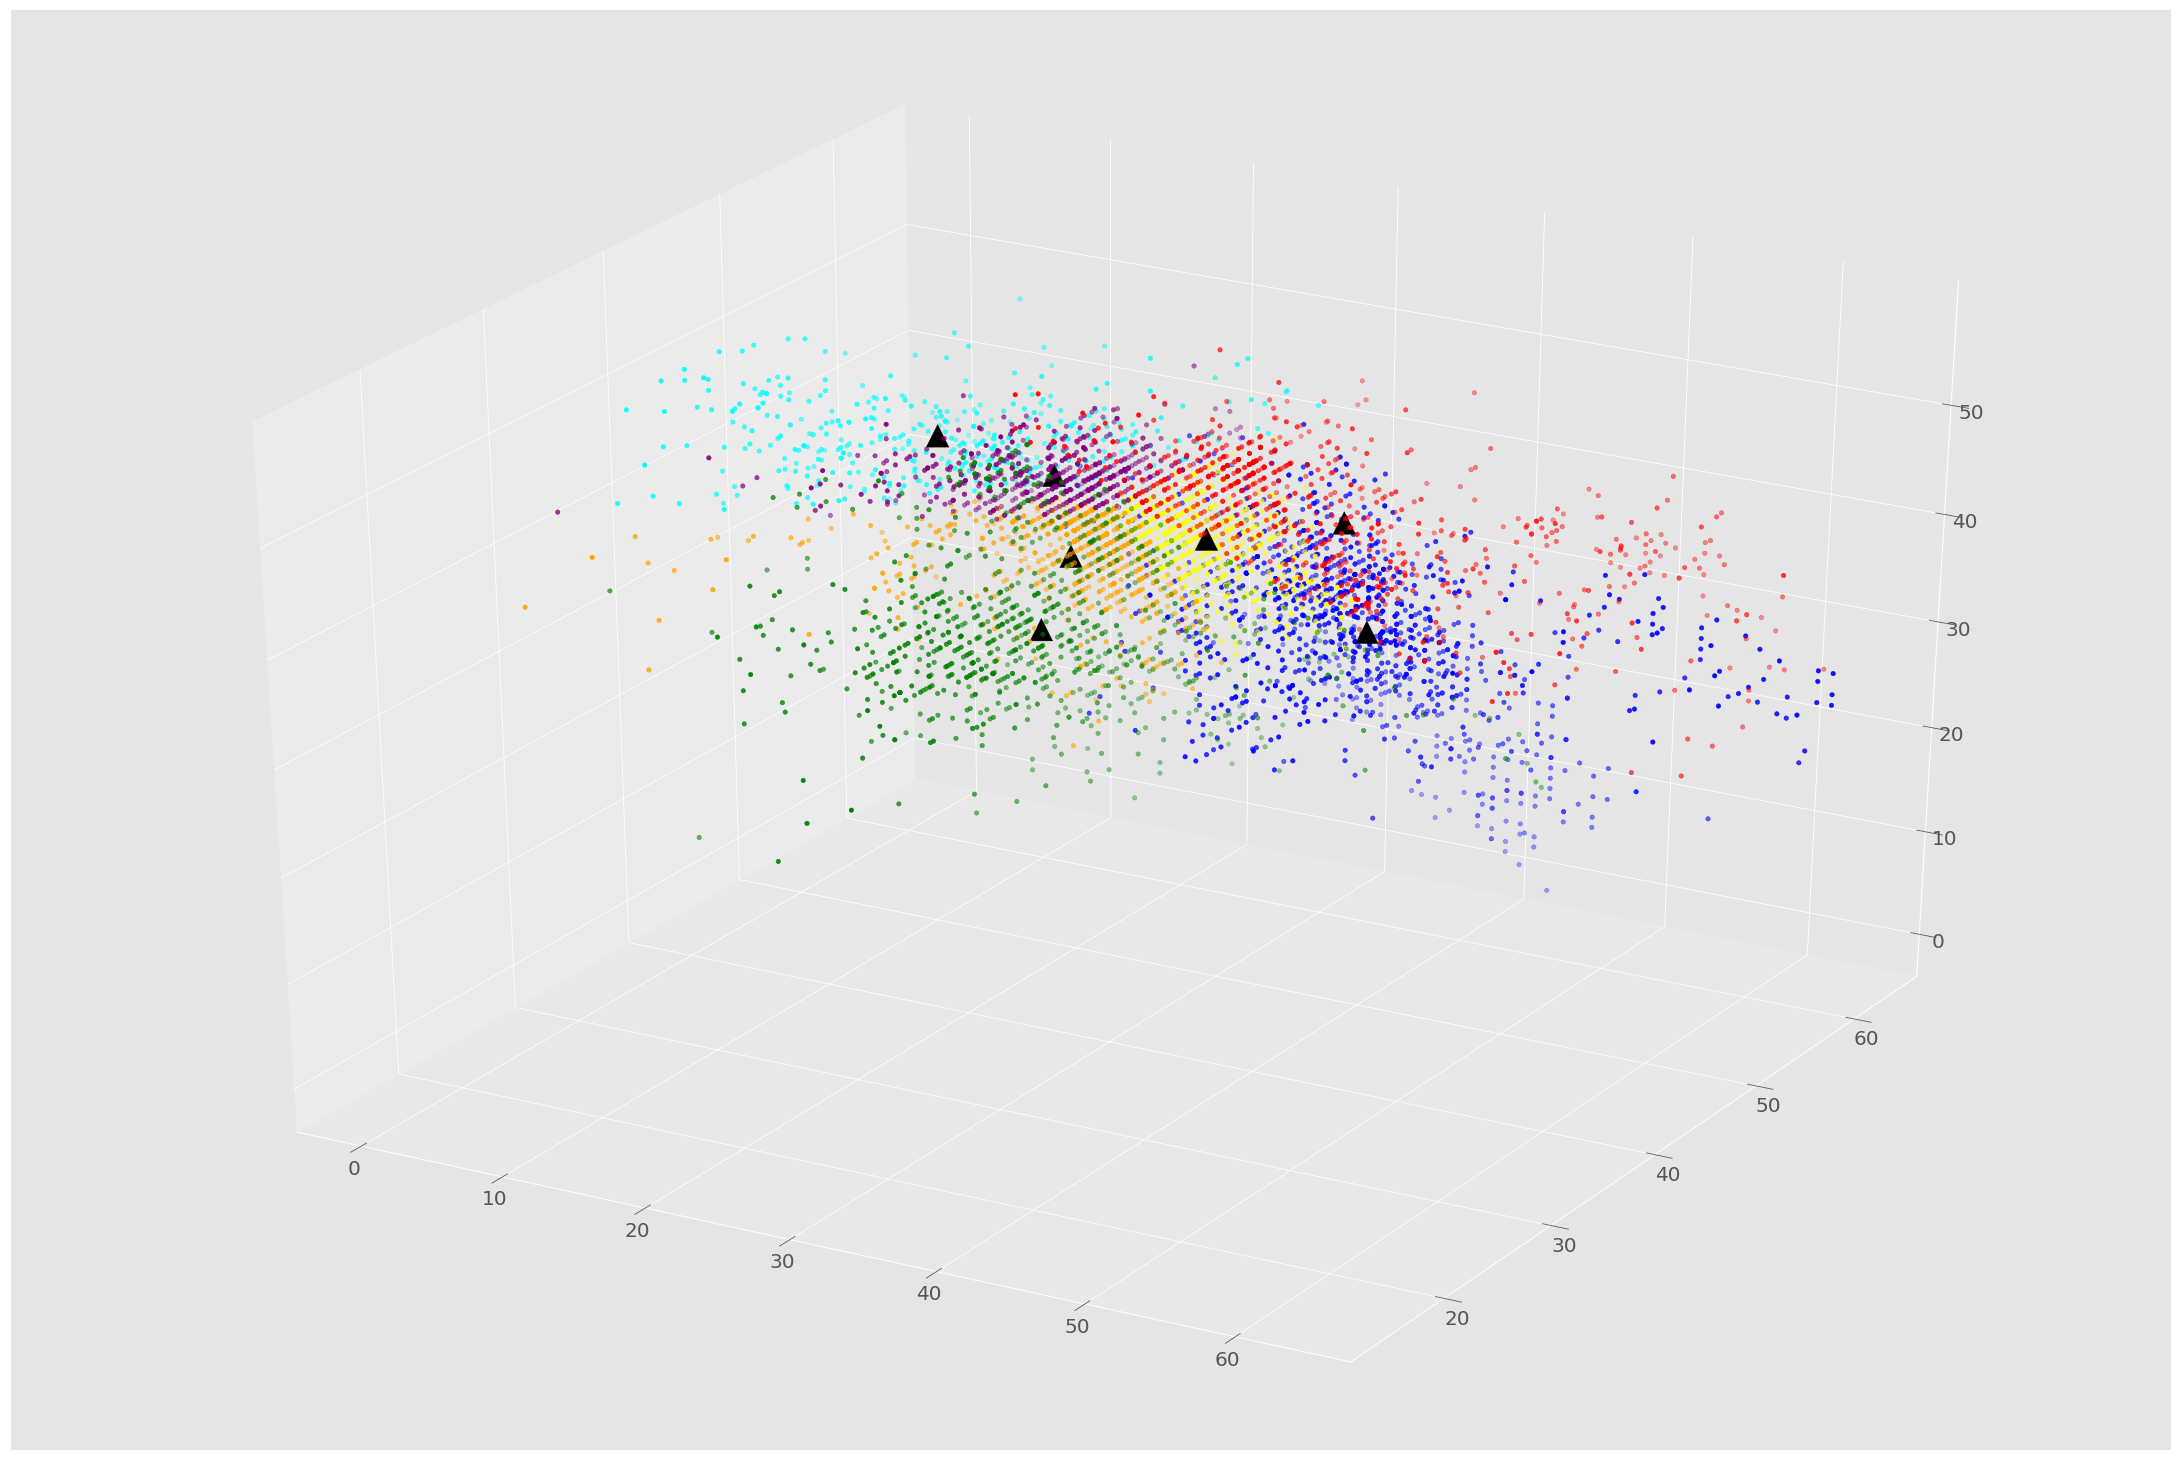

In [7]:
def plot_results(K, data_matrix, data_labels, final_centroid_matrix):
    """
    Plots the data based on the cluster labels given. Also plots each centroid as black triangles.
    Can only be used with 2d or 3d data, and plots for up to K=10.
    
    Args:
        K (int): number of clusters
        data_matrix (np.ndarray): array of data
        data_labels (list): list of cluster labels for each data point
        final_centroid_matrix (np.ndarray): array of final centroid points
    """
    
    # get n and number of axes
    n,axes = data_matrix.shape
    
    # list of colors to plot with
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'cyan', 'magenta',
              'brown', 'grey']
    
    if (axes == 2):
        # plot each cluster using matplotlib
        labeled_data_matrix = np.c_[data_matrix, data_labels]
        for cluster_num in range(K):
            cluster_matrix = labeled_data_matrix[labeled_data_matrix[:,axes] == cluster_num]
            plt.scatter(cluster_matrix[:,0], cluster_matrix[:,1], c=colors[cluster_num])
        
        # plot centroids as black triangles
        plt.scatter(final_centroid_matrix[:,0], final_centroid_matrix[:,1], c='black', s=500, marker='^', alpha=1)
        
        plt.show()
    elif (axes == 3):
        figure = Axes3D(plt.figure())
        
        # plot each cluster using Axes3D
        labeled_data_matrix = np.c_[data_matrix, data_labels]
        for cluster_num in range(K):
            cluster_matrix = labeled_data_matrix[labeled_data_matrix[:,axes] == cluster_num]
            figure.scatter(cluster_matrix[:,0], cluster_matrix[:,1], cluster_matrix[:,2], c=colors[cluster_num])
        
        # plot cluster centers in black triangles
        figure.scatter(final_centroid_matrix[:,0], final_centroid_matrix[:,1], 
                       final_centroid_matrix[:,2], c='black', s=500, marker='^', alpha=1)
        
        # increase label size
        figure.tick_params(axis='both', which='major', labelsize=20)
        return
    else:
        print("Function only works with 2d or 3d data.")
    return

plot_results(7, brush_data, brush_labels, final_brush_centroids)

`K_means` is a wrapper function for all the functionality of the Kmeans clustering algorithm. As you can see, the resulting plot is different from when we called `init_centroid_matrix` then `converge_clusters`. We will touch upon why this is in the next section.

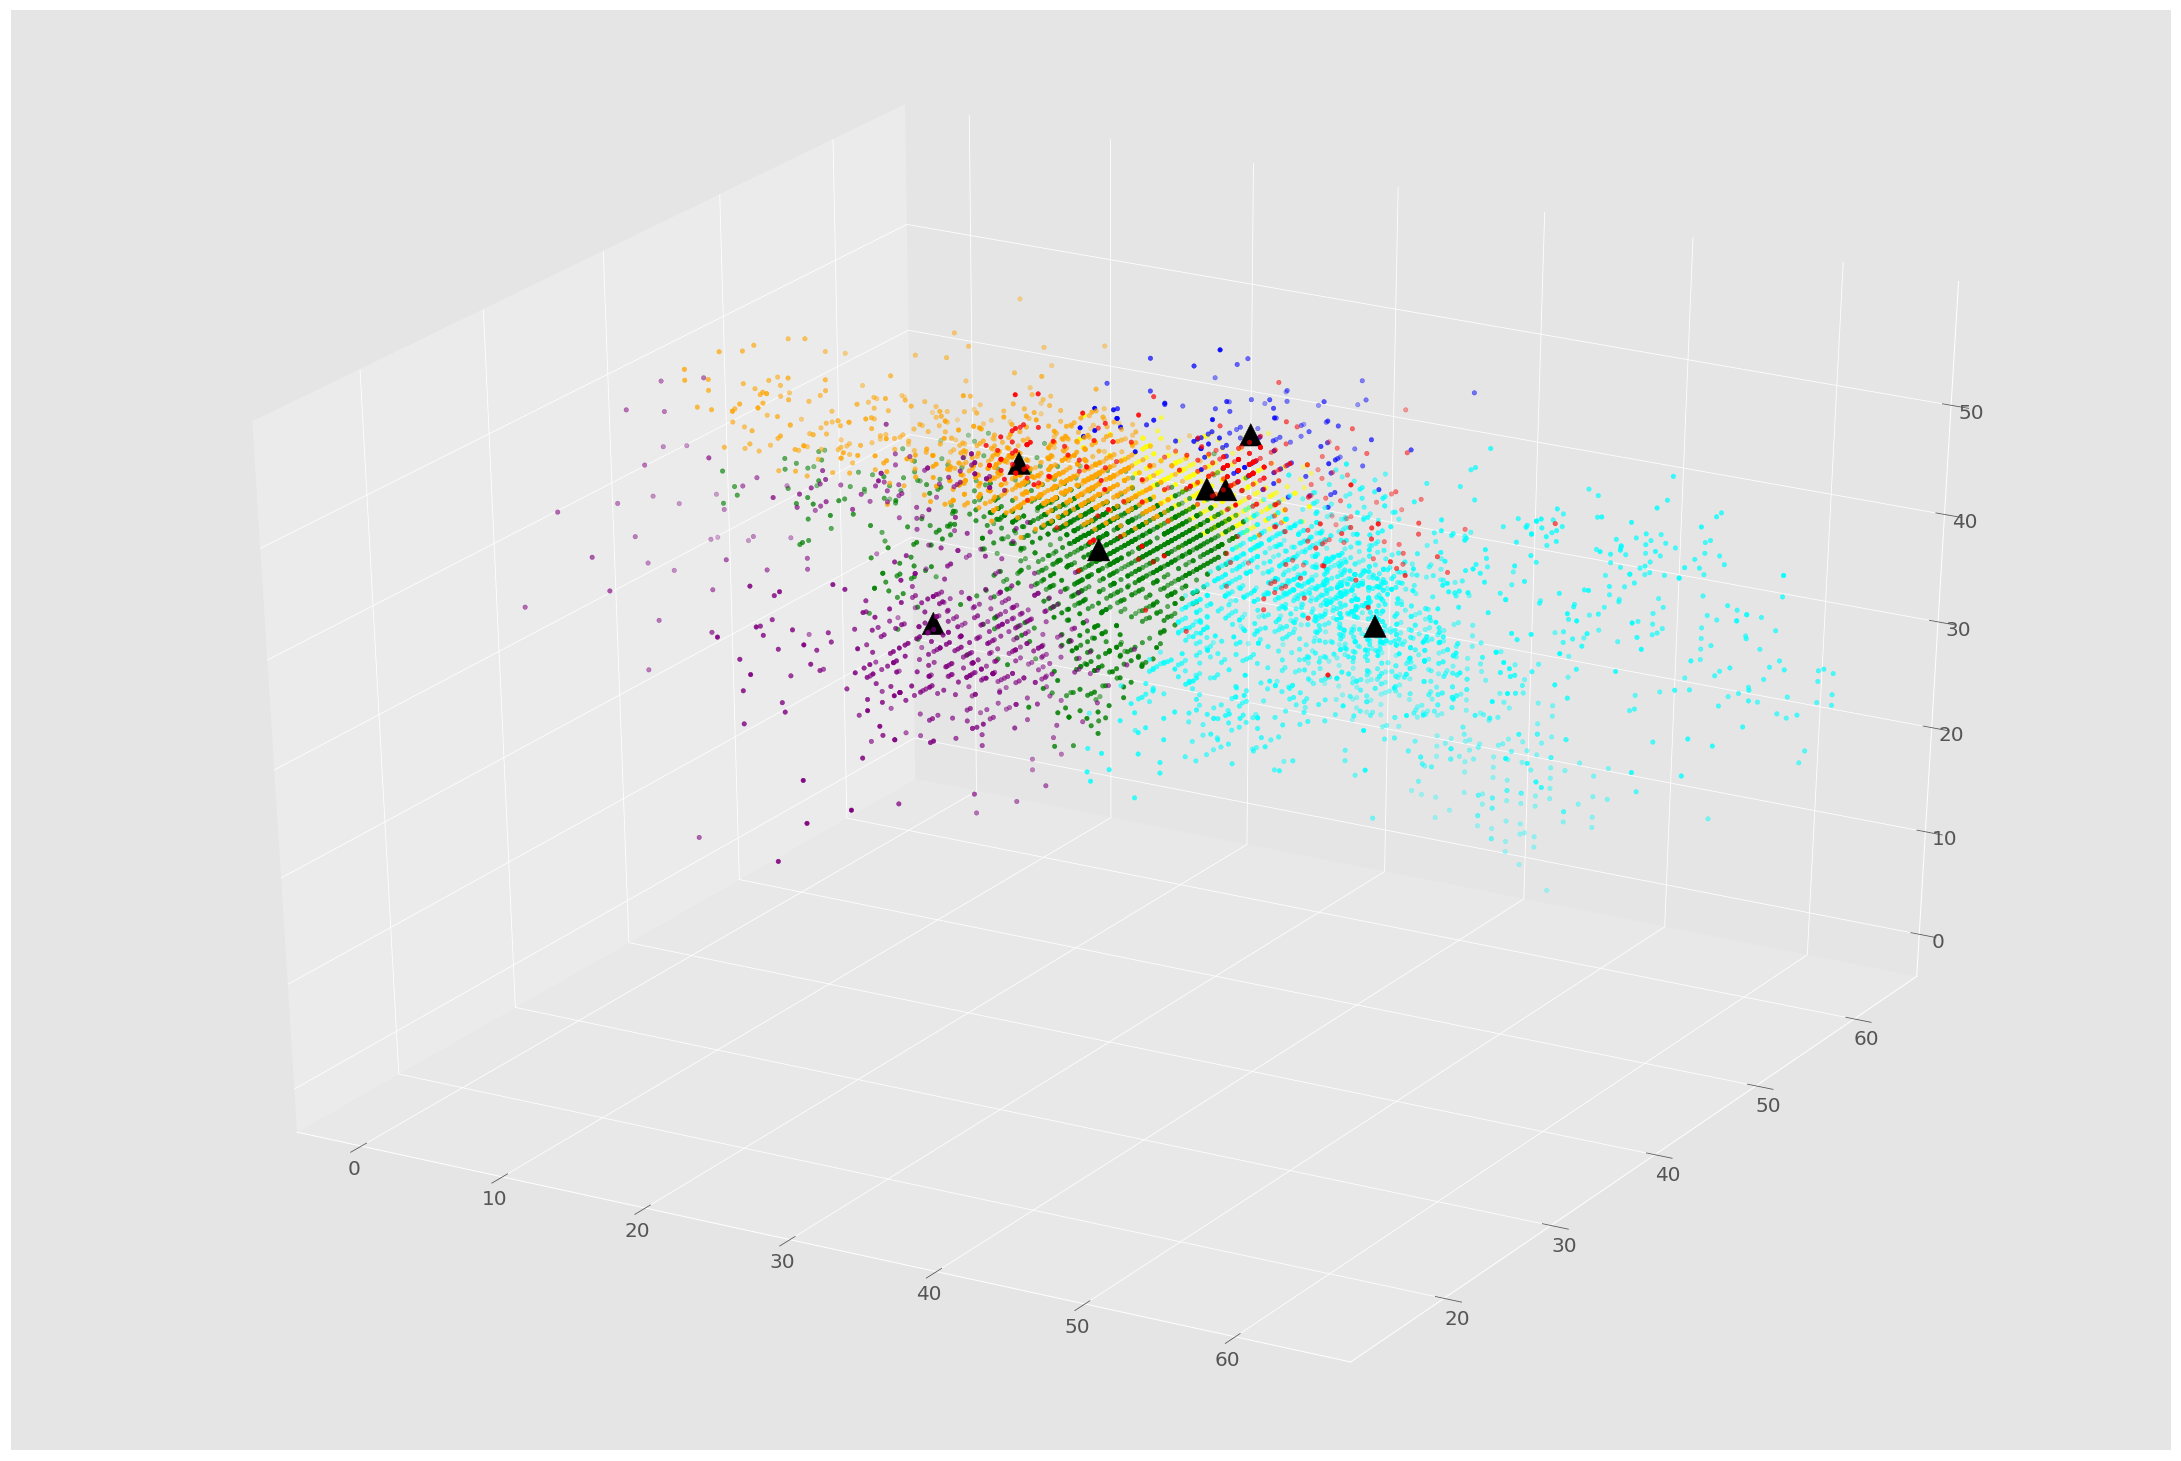

In [8]:
def K_means(K, data_matrix):
    """
    Wrapper for performing the Kmeans algorithm and plotting the results.
    """
    data_labels, final_centroid_matrix = converge_clusters(K, data_matrix, init_centroid_matrix(K, data_matrix))
    plot_results(K, data_matrix, data_labels, final_centroid_matrix)

K_means(7, brush_data)

# 5. Pros and cons of Kmeans

Kmeans is relatively easy to implement, and the easy to read implementation provided in this tutorial can be sped up and shortened using matrix multiplication. Sklearn provides an implementation that is easy to use. However, Kmeans falls short in a few aspects.

### Pros
1. Easy and quick to learn
2. Within-cluster variation always decreases with each iteration in converge_clusters
3. Regardless of how bad the initial guesses for the cluster centers are, the algorithm always converges.

### Cons
1. The final cluster centers found by the algorithm depend heavily upon the initial cluster center guesses. This is illustrated by how the results above from running init_center_matrix/converge_clusters separately vs. together in the wrapper function are different.
2. The algorithm finds a local optimum, not the global optimum. Thus, within-cluster variation may not be minimized.
3. It is not always apparent what $K$ should be, especially with higher dimensional data sets, as it is harder to eyeball a graph of the data and guess $K$. For example, with the brushing data, if we set $K=2$, we would most likely just get the data split down the middle, which doesn't really help us visualize anything we couldn't see without running Kmeans.

### Improving Kmeans

To minimize within-cluster variation as much as possible, the easiest strategy is to run the algorithm multiple times, choosing the result that gives the smallest in-cluster variation.

To choose the best $K$, the method most commonly used is the elbow method. The algorithm is run multiple times with different $K$ values, and each $K$ is plotted again the sum of squared errors between the points and the cluster centers. The point plotted closest to the "elbow" of the graph has the optimal $K$ value. For example, in the graph below, the optimal $K$ would be 3.

<img src="https://www.jeremyjordan.me/content/images/2016/12/BzwBY.png" width="400" height="400" />

Now, let's implement the elbow method. `find_error` below gives us the within cluster variation.

In [9]:
def find_error(data_matrix, data_labels, final_centroid_matrix):
    """
    Finds sum of squared errors for provided data and Kmeans centroids.
    
    Args:
        data_matrix (np.ndarray): array of data
        data_labels (list): list of cluster labels for each data point
        final_centroid_matrix (np.ndarray): array of final centroid points
    """
    
    # get n and number of axes
    n,axes = data_matrix.shape
    
    # sum up all squared errors
    sse = 0
    # calculate squared error for each point
    for point_num in range(n):
        point = data_matrix[point_num,:]
        centroid = final_centroid_matrix[data_labels[point_num]]
        sse += np.linalg.norm(point-centroid)**2
    
    return sse

find_error(brush_data, brush_labels, brush_centroids)

699379.0

`plot_elbow` iterates across all K values specified, performing Kmeans on the data 10 times for each K. It then returns the (K,sse) pairs to plot, along with the best values for the centroids. The call to the plot method plots the points, and we can see that the elbow isn't as apparent for this dataset, showing that clustering may not be the best way to analyze this data set. However, if we were to take a guess at what the optimal k is, it would be 7.

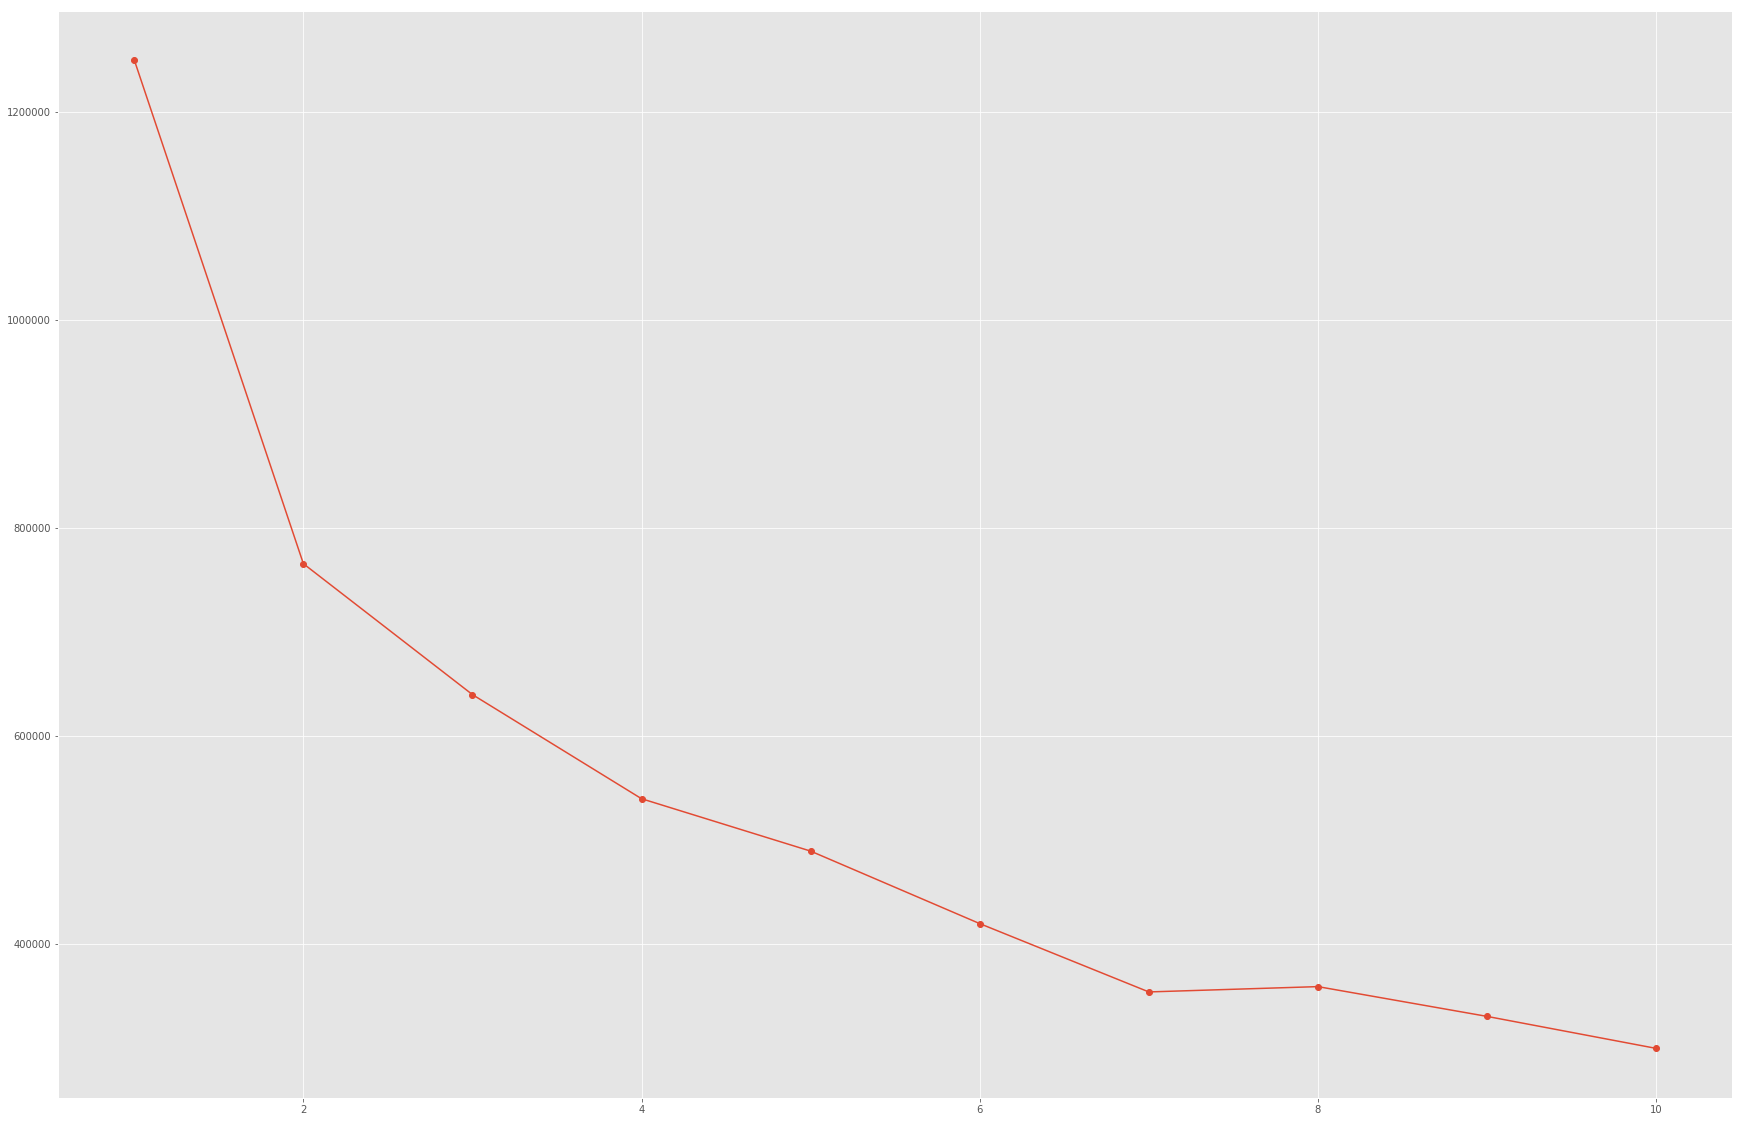

In [10]:
def plot_elbow(data_matrix, K_start, K_finish):
    """
    Finds sum of squared errors for provided data and Kmeans centroids.
    
    Args:
        data_matrix (np.ndarray): array of data
        K_start (int): first value of K to plot sse of
        K_stop (int): last value of K to plot sse of
    """
    
    elbow_X, elbow_Y, centroid_matrices = [],[],[]
    
    # iterate across all specified K values
    for K in range(K_start, K_finish + 1):
        best_sse = None
        best_centroid_matrix = None
        
        # find best_sse and best_centroid_matrix
        for trial in range(10):
            data_labels, final_centroid_matrix = converge_clusters(K, data_matrix, init_centroid_matrix(K, data_matrix))
            sse = find_error(data_matrix, data_labels, final_centroid_matrix)
            if ((best_sse == None) or (sse < best_sse)):
                best_sse = sse
                best_centroid_matrix = final_centroid_matrix
                
        # append K, best_sse, and best_centroid_matrix
        elbow_X.append(K)
        elbow_Y.append(best_sse)
        centroid_matrices.append(best_centroid_matrix)
    
    return elbow_X, elbow_Y, centroid_matrices

elbow_X, elbow_Y, centroid_matrices = plot_elbow(brush_data, 1, 10)

# plot with circle markers and solid line
plt.plot(elbow_X, elbow_Y, 'o-')

Using what we've learned from the elbow method, we can graph the data with the best centroids for $K=7$.

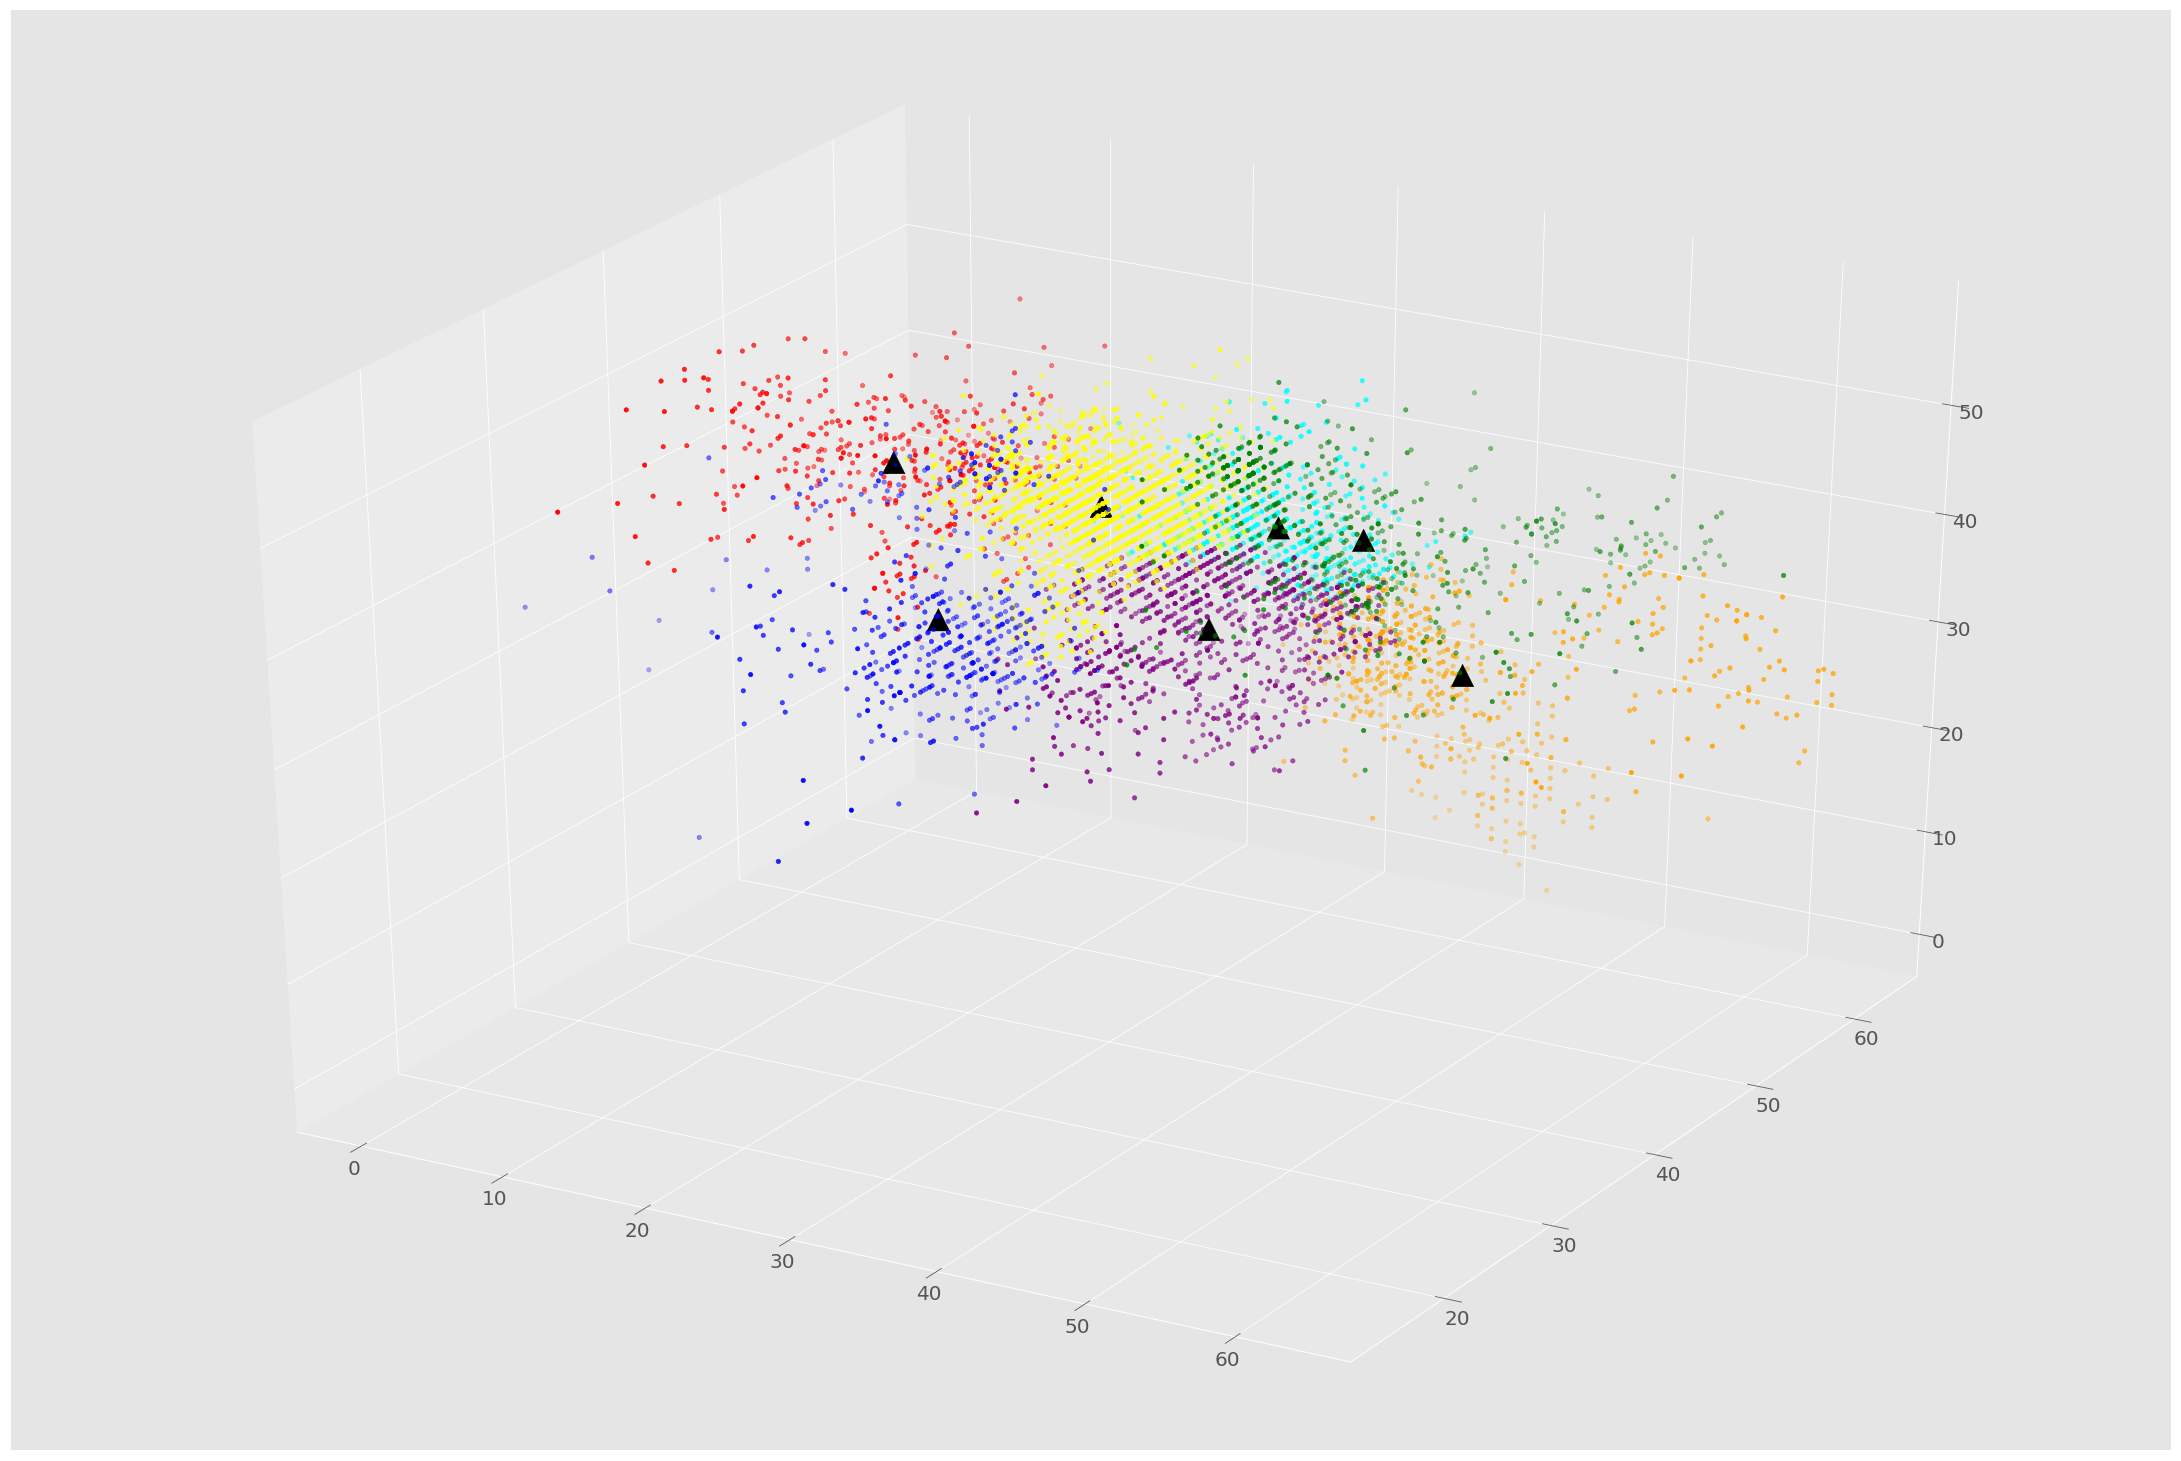

In [12]:
data_labels, final_centroid_matrix = converge_clusters(7, brush_data, centroid_matrices[7])
plot_results(7, brush_data, data_labels, final_centroid_matrix)

# 6. Example: Image compression with Kmeans

One application of Kmeans is to use it for compressing images. In an image, each pixel has an rgb value, and a group of pixels can be represented as an array of rgb values, or a point. An image can thus be divided into groups of pixels and converted into a matrix of points. Using Kmeans, each point can be assigned to a cluster. The image can then be compressed by setting all points equal to their centroid, making the image consist of only a few distinct pixel groups. To illustrate this process, we will use the `PIL` library. It allows us to open images and load them as arrays of pixel values, as well as change those values and save the pixel value array back to an image.

In [13]:
from PIL import Image

For this example, each pixel group will be a $2x2$ block of pixels. This converts into a 4d point. We will use $K=4$, meaning the processed image will only be made of 4 different $2x2$ pixel blocks.

The image we will be using is downloaded from http://www.knowol.com/wp-content/uploads/2016/08/andrew-carnegie-inspiration-932x640.jpg:

<img src="http://www.knowol.com/wp-content/uploads/2016/08/andrew-carnegie-inspiration-932x640.jpg" width="400" height="400" />

Save it as `andrew_carnegie.jpg` in the same directory as this notebook.

We first open the image and calculate the number of columns and rows of $2x2$ pixel blocks, then convert each block into a vector using `block2vector`, combining the vectors to get a matrix of data points.

In [14]:
# open image
carnegie_img = Image.open("andrew_carnegie.jpg")
carnegie_pxl = carnegie_img.load()

# get number of columns and rows of 2x2 pixel blocks
cols, rows = carnegie_img.size
cols, rows = cols//2, rows//2

# helper function for converting a 2x2 pixel block to a vector
def block2vector(row, col, pixel_array):
    vector = []
    # go from top to bottom, left to right
    for i in range(row*2, row*2+2):
        for j in range(col*2, col*2+2):
            # check if greyscale or color
            color = pixel_array[j,i]
            if (type(color) == tuple):
                value = color[0] << 16 + color[1] << 8 + color[2]
            else:
                value = color
            vector.append(value)
    return vector

# get each point
carnegie_data = []
for row in range(rows):
    for col in range(cols):
        carnegie_data.append(block2vector(row, col, carnegie_pxl))

# get data matrix
carnegie_data = np.vstack(tuple(carnegie_data))

print(carnegie_data.shape)
carnegie_data

(149120, 4)


array([[125, 141, 138, 146],
       [155, 161, 155, 162],
       [169, 181, 170, 180],
       ..., 
       [126, 133, 126, 135],
       [144,  81, 144,  80],
       [  0,   7,   0,   7]])

We then perform the KMeans algorithm on the data.

In [15]:
carnegie_labels, carnegie_centroids = converge_clusters(4, carnegie_data, init_centroid_matrix(4, carnegie_data))

carnegie_centroids

array([[ 207.37100013,  207.37470433,  207.08997188,  207.14044718],
       [ 183.7760956 ,  183.89564141,  183.62976981,  183.6614535 ],
       [ 222.52729915,  222.52304339,  222.43817037,  222.47232025],
       [ 117.98451668,  118.14669725,  117.87568546,  118.04406652]])

The final step is to replace each point in the data with its cluster's centroid. Image-wise, this corresponds to replacing the $2x2$ pixel block each point represents with the $2x2$ pixel block corresponding to the centroid of that point. We define `vector2block` to help save each vector to the pixel blocks. The resulting image is shown below.

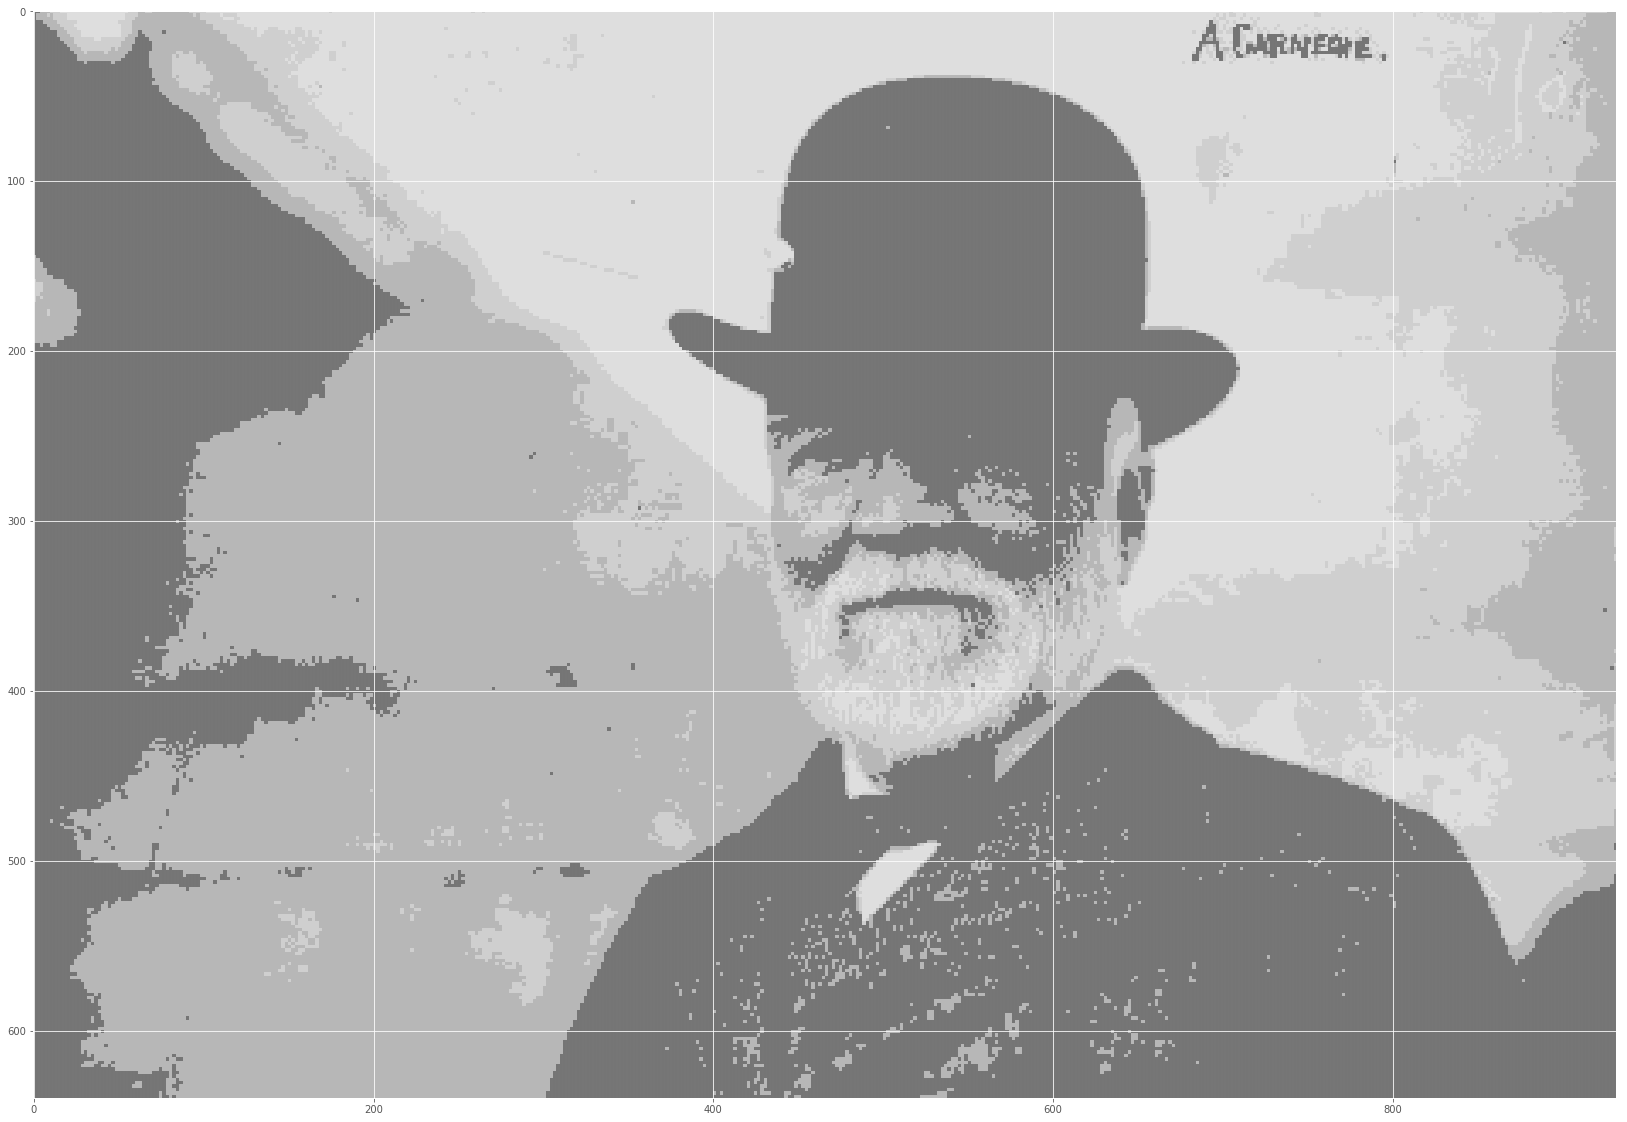

In [16]:
# helper function for saving a vector to a 2x2 pixel block
def vector2block(row, col, pixel_array, vector):
    # go from top to bottom, left to right
    for i in range(row*2, row*2+2):
        for j in range(col*2, col*2+2):
            # some messy calculation here to iterate across vector[0] to vector[3]
            pixel_array[j,i] = int(vector[(i-row*2)*2 + j-col*2])

# save each block
for row in range(rows):
    for col in range(cols):
        block_num = row*cols + col
        centroid = carnegie_centroids[carnegie_labels[block_num],:]
        vector2block(row, col, carnegie_pxl, centroid)

# display the compressed image
plt.imshow(np.asarray(carnegie_img), cmap='gray',vmin=0,vmax=255)

# 7. Related topics

1. Voronoi tesselation: After running KMeans and finding the centroids, the whole coordinate plane can be labeled as being closest to a specific centroid, thus dividing the plane into K regions.
2. Kmedoids: Algorithm very similar to Kmeans, where the goal is to have each final centroid be a point from the data set. It is computationally harder and generally has more within-cluster variation.
3. Kmeans++: Algorithm for choosing the centroid guesses used in the initial iteration for Kmeans. It uses weighted probability distributions to choose the guesses.
4. Anomaly detection: Kmeans can be used to detect anomalies in data, and this page does that with waveforms: http://amid.fish/anomaly-detection-with-k-means-clustering